In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, norm

from dataset import load_from_csv, remove_payment_duplicates, remove_user_group_duplicates


sns.set_style(rc={"figure.figsize": (8, 3)})
warnings.filterwarnings("ignore")

In [2]:
def plot_ci(
        dataset: pd.DataFrame,
        group_var: str,
        value_var: str
):
    plt.figure(figsize=(6, 3))
    sns.pointplot(
        x=group_var,
        y=value_var,
        data=dataset,
        ci=95,
        capsize=0.1,
        join=False
    )
    plt.title("CI (95%) by group")
    plt.xlabel("Group")
    plt.ylabel("Value")
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [121]:
def compare_conversions(
        dataset: pd.DataFrame,
        var: str
):
    arr1 = dataset.query("ab_group == 1")[var].values
    arr2 = dataset.query("ab_group == 2")[var].values

    stat, pval = proportions_ztest(
        count=[arr1.sum(), arr2.sum()],
        nobs=[len(arr1), len(arr2)]
    )

    print("Group 1:   {:.3f}".format(arr1.mean()))
    print("Group 2:   {:.3f}".format(arr2.mean()))
    print("Z-stat:    {:.3f}".format(stat))
    print("p-value:   {:.5f}".format(pval))

def compare_means(
        dataset: pd.DataFrame,
        var: str
):
    arr1 = dataset.query("ab_group == 1")[var].values
    arr2 = dataset.query("ab_group == 2")[var].values

    stat, pval = ttest_ind(
        a=arr1,
        b=arr2,
        equal_var=False
    )

    print("Group 1:   {:.3f}".format(arr1.mean()))
    print("Group 2:   {:.3f}".format(arr2.mean()))
    print("t-stat:    {:.3f}".format(stat))
    print("p-value:   {:.5f}".format(pval))


def bootstrap_ratio_diff(arr1, arr2, n_iter=10_000):
    n1, n2 = len(arr1), len(arr2)
    diffs = []

    for _ in range(n_iter):
        sample1 = arr1[np.random.choice(n1, size=n1, replace=True)]
        sample2 = arr2[np.random.choice(n2, size=n2, replace=True)]

        num1, den1 = sample1[:, 0].sum(), sample1[:, 1].sum()
        num2, den2 = sample2[:, 0].sum(), sample2[:, 1].sum()

        ratio1 = num1 / den1
        ratio2 = num2 / den2

        diffs.append(ratio2 - ratio1)

    diffs = np.array(diffs)

    mean_diff = diffs.mean()
    std_diff = diffs.std(ddof=1)

    z_score = -abs(mean_diff) / std_diff
    p_value = 2 * norm.cdf(z_score)

    return p_value


def compare_ratios(
        dataset: pd.DataFrame,
        var1: str,
        var2: str
):
    arr1 = dataset.query("ab_group == 1")[[var1, var2]].values
    arr2 = dataset.query("ab_group == 2")[[var1, var2]].values

    pval = bootstrap_ratio_diff(arr1, arr2)

    print("Group 1:    {:.3f}".format(arr1[:, 0].sum() / arr1[:, 1].sum()))
    print("Group 2:    {:.3f}".format(arr2[:, 0].sum() / arr2[:, 1].sum()))
    print("p-value:    {:.5f}".format(pval))

### Loading & Cleaning Data

In [3]:
ab_df = load_from_csv()

In [6]:
ab_df = remove_payment_duplicates(ab_df)

No. of duplicates:  90
No. of payments:    0


In [7]:
ab_df = remove_user_group_duplicates(ab_df)

No. of users duplicated across groups:   3


In [9]:
print("Rows count:         {}".format(ab_df.shape[0]))
print("Users count:        {}".format(ab_df["user_id"].nunique()))

Rows count:         83241
Users count:        72850


### Making dataset for statistical analysis

All payments are collected within 0-30 days after install

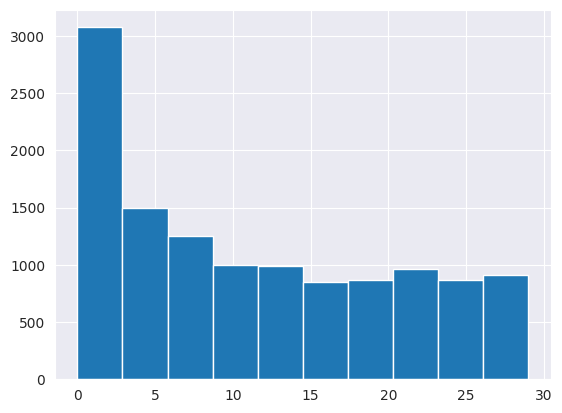

In [57]:
((ab_df["payment_time"] - ab_df["install_time"]).dt.days).hist()
plt.show()

In [32]:
ab_df["revenue"] = ab_df["amount"].fillna(0)

In [88]:
ab_dataset = (
    ab_df
    .groupby("user_id", as_index=False)
    .agg(
        payments_count=("payment_time", "count"),
        total_revenue=("revenue", "sum"),
        first_payment_time=("payment_time", "min")
    )
    .merge(
        ab_df.drop_duplicates(subset="user_id")[["user_id", "ab_group", "install_time", "cost"]],
        on="user_id"
    )
)
ab_dataset["conversion_to_payment"] = ab_dataset["payments_count"] > 0
ab_dataset["days_to_first_payment"] = (ab_dataset["first_payment_time"] - ab_dataset["install_time"]).dt.days

In [89]:
ab_stats = (
    ab_dataset
    .groupby("ab_group", as_index=False)
    .agg(
        users_count=("user_id", "nunique"),
        cr_to_payment=("conversion_to_payment", "mean"),
        avg_days_to_first_payment=("days_to_first_payment", "mean"),
        avg_payments_count=("payments_count", "mean"),
        total_payments_count=("payments_count", "sum"),
        total_revenue=("total_revenue", "sum"),
        total_cost=("cost", "sum"),
        avg_cost=("cost", "mean")
    )
)
ab_stats["avg_payment"] = ab_stats["total_revenue"] / ab_stats["total_payments_count"]
ab_stats["arpu"] = ab_stats["total_revenue"] / ab_stats["users_count"]
ab_stats["roas"] = ab_stats["total_revenue"] / ab_stats["total_cost"]

Stats by groups

In [90]:
ab_stats[[
    "ab_group",
    "cr_to_payment",
    "avg_days_to_first_payment",
    "avg_payments_count",
    "avg_payment",
    "arpu",
    "avg_cost",
    "roas"
]]

,ab_group,cr_to_payment,avg_days_to_first_payment,avg_payments_count,avg_payment,arpu,avg_cost,roas
0,1,0.023540,4.230317,0.170147,1805.047797,307.124257,699.890862,0.438817
1,2,0.027603,3.403751,0.166326,1388.886959,231.008093,699.751675,0.330129


# Statistical tests

### CR to payment

In [93]:
compare_conversions(
    dataset=ab_dataset,
    var="conversion_to_payment"
)

Group 1:   0.024
Group 2:   0.028
Z-stat:    -3.472
p-value:   0.00052


### No. of payments per user

In [94]:
compare_means(
    dataset=ab_dataset,
    var="payments_count"
)

Group 1:   0.170
Group 2:   0.166
t-stat:    0.283
p-value:   0.77705


### Average payment value

In [123]:
compare_ratios(
    dataset=ab_dataset,
    var1="total_revenue",
    var2="payments_count"
)

Group 1:    1805.048
Group 2:    1388.887
p-value:    0.04543


### ARPU

In [124]:
compare_means(
    dataset=ab_dataset,
    var="total_revenue"
)

Group 1:   307.124
Group 2:   231.008
t-stat:    1.628
p-value:   0.10353


### ROAS

In [120]:
compare_ratios(
    dataset=ab_dataset,
    var1="total_revenue",
    var2="cost"
)

Group 1:    0.439
Group 2:    0.330
p-value:    0.10833
